[View in Colaboratory](https://colab.research.google.com/github/vivianistan/mbti-classification/blob/master/rf_mbti.ipynb)

# Preprocessing: 

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [0]:
!pip install -q xgboost==0.4a30
import xgboost as xgb

In [0]:
!pip install -q nltk
import nltk

In [0]:
#@title
!pip install textblob
!python -m textblob.download_corpora
from textblob import TextBlob

In [31]:
# Uploading files: 
from google.colab import files
uploaded = files.upload()
# https://drive.google.com/uc?export=download&id=1gA1-QtRcz0tR44RrgdB6s7wlmRVxfQU2


In [0]:
# !pip install spacy

In [0]:
# !python -m spacy download en
# import spacy

In [34]:
df_train = pd.read_csv('mbti_1.csv')
df_train.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [0]:
print(df_train.columns)

In [0]:
# Check for null data


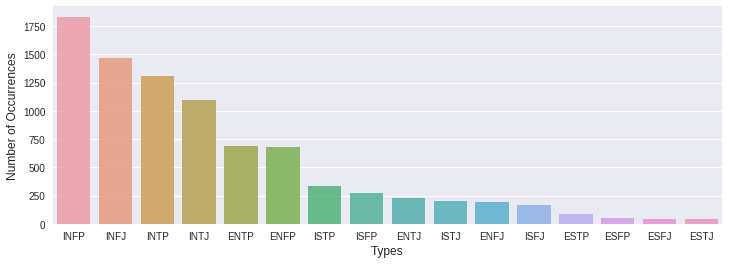

In [36]:
# How many of each type? (https://www.kaggle.com/lbronchal/what-s-the-personality-of-kaggle-users)
cnt_srs = df_train['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

Very unbalanced data set

In [0]:
# one_hot_encoded_training_predictors = pd.get_dummies(df_train)
# one_hot_encoded_training_predictors

NLTK processing: 


In [0]:
# import nltk
# nltk.download('stopwords'),nltk.download('porter_test'), nltk.download('punkt')

In [0]:
from nltk import word_tokenize

Helpful link for using spaCy: 
* https://nlpforhackers.io/complete-guide-to-spacy/ 
* https://spacy.io/usage/linguistic-features#section-pos-tagging


List of part of speech tags: https://stackoverflow.com/questions/1833252/java-stanford-nlp-part-of-speech-labels 


Common part of speech tags:

| Tag  | Meaning | English example  |
| --- |---| ---|
| JJ | adjective | new, good, special |
| IN | adposition     |   on, of, at, under |
| RB| adverb  | really, early, already
|CC|conjunction|and, or, but, if, although
|DET|determiner/article |the, a, some, most, which
|NN| noun|year, home, time
|NNP| proper noun| Madrid, Paris, Austin
|VB*|verb| is, run, play
|NUM| numeral| twenty, 12, 2018, 12:32
|PRP|preposition|my, I, we
|UH| interjection| Ah! wow!
|.| punctuation| ?, !, .


In [0]:
# # Part of speech tagging example:
# import spacy

# raw = 'wow! the quick brown fox jumped over the sleeping dog right then'

# nlp = spacy.load('en')
# doc = nlp(unicode(raw))
# print([(token.text, token.tag_) for token in doc])


In [0]:
# import re
# # Use regular expressions to do a find-and-replace
# letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
#                       " ",                   # The pattern to replace it with
#                       example1.get_text() )  # The text to search
# print letters_only

In [0]:
# # Idea: count avg number of NN, JJ, etc. per comment 
# num_JJ = num_NN = num_PRP =  num_VB = num_NNP = num_DT = 0
# for token in doc:
#   if token.tag_ == 'NN': 
#     num_NN +=1
    
# print(num_NN)

In [0]:
# text = nltk.word_tokenize(raw)
# tags = nltk.pos_tag(text)
# count = 0
# for word, tag in tags:
#   if tag == 'JJ':
#     count += 1
#     print(tag)
  
# print count

## Feature engineering: 

Add features: 
* words per comment
* variance of word counts
* number of different parts of speech (determiners, articles, adjectives, adverbs, pronouns, punctuation marks (?!))
* links per comment
* images per comment
* ellipsis per comment



reference: https://www.kaggle.com/laowingkin/mbti-study-personality 

In [0]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

In [0]:
# Add part of speech tag column:


In [44]:
# From kaggle: add words per comment/variance of word counts 
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)
  

# add features:
df_train['words_per_comment'] = df_train['posts'].apply(lambda x: len(x.split())/50.0)
df_train['variance_of_word_counts'] = df_train['posts'].apply(lambda x: var_row(x))

df_train['http_per_comment'] = df_train['posts'].apply(lambda x: x.count('http')/50.0)
df_train['img_per_comment'] = df_train['posts'].apply(lambda x: x.count('jpg')/50.0)

df_train['qm_per_comment'] = df_train['posts'].apply(lambda x: x.count('?')/50.0)
df_train['excl_per_comment'] = df_train['posts'].apply(lambda x: x.count('!')/50.0)
df_train['ellipsis_per_comment'] = df_train['posts'].apply(lambda x: x.count('...')/50.0)

df_train['E'] = df_train['type'].apply(lambda x: x.count('E'))
df_train['I'] = df_train['type'].apply(lambda x: x.count('I'))

df_train['S'] = df_train['type'].apply(lambda x: x.count('S'))
df_train['N'] = df_train['type'].apply(lambda x: x.count('N'))

df_train['F'] = df_train['type'].apply(lambda x: x.count('F'))
df_train['T'] = df_train['type'].apply(lambda x: x.count('T'))

df_train['P'] = df_train['type'].apply(lambda x: x.count('P'))
df_train['J'] = df_train['type'].apply(lambda x: x.count('J'))

# # Parts of speech
# nlp = spacy.load('en')
# tag_dict
# df_train
# df_train['nouns_per_comment'] = df_train['posts'].apply(lambda x: nouns_row(x))
# df_train['adjs_per_comment'] = df_train['posts'].apply(lambda x: adjs_row(x))
# df_train['advs_per_comment'] = df_train['posts'].apply(lambda x: advs_row(x))
# df_train['adps_per_comment'] = df_train['posts'].apply(lambda x: adps_row(x))
# df_train['conjs_per_comment'] = df_train['posts'].apply(lambda x: conjs_row(x))
# df_train['articles_per_comment'] = df_train['posts'].apply(lambda x: articles_row(x))
# df_train['prop_nouns_per_comment'] = df_train['posts'].apply(lambda x: prop_nouns_row(x))
# df_train['verbs_per_comment'] = df_train['posts'].apply(lambda x: verbs_row(x))
# df_train['numerals_per_comment'] = df_train['posts'].apply(lambda x: numerals_row(x))
# df_train['preps_per_comment'] = df_train['posts'].apply(lambda x: preps_row(x))
# df_train['intjecs_per_comment'] = df_train['posts'].apply(lambda x: intjecs_row(x))
# df_train['puncts_per_comment'] = df_train['posts'].apply(lambda x: puncts_row(x))

df_train.head()

,type,posts,words_per_comment,variance_of_word_counts,http_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,E,I,S,N,F,T,P,J
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,0.48,0.12,0.36,0.06,0.30,0,1,0,1,1,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,0.20,0.02,0.10,0.00,0.38,1,0,0,1,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,0.10,0.00,0.24,0.08,0.26,0,1,0,1,0,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,0.04,0.00,0.22,0.06,0.52,0,1,0,1,0,1,0,1
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,0.12,0.04,0.20,0.02,0.42,1,0,0,1,0,1,0,1


In [45]:
# Parts of Speech Functions  
# Note: running each function takes ~9 min each

def nouns_row(row):
  num_adjs = 0
  for i in row.split('|||'):
    i = nltk.re.findall(r"\w+(?:[-']\w+)*|'|[-.(]+|\S\w*", i)
    tags = nltk.pos_tag(i)
    for word,tag in tags:
      if tag == 'NN': 
        num_adjs += 1
  return num_adjs

def adjs_row(row):
  num_adjs = 0
  for i in row.split('|||'):
    i = nltk.re.findall(r"\w+(?:[-']\w+)*|'|[-.(]+|\S\w*", i)
    tags = nltk.pos_tag(i)
    for word,tag in tags:
      if tag == 'JJ': 
        num_adjs += 1
  return num_adjs


def verbs_row(row):
  num_adjs = 0
  for i in row.split('|||'):
    i = nltk.re.findall(r"\w+(?:[-']\w+)*|'|[-.(]+|\S\w*", i)
    tags = nltk.pos_tag(i)
    for word,tag in tags:
      valid = re.search(r"(VB[D|G|Z|P|N]*)", tag)
      if valid: 
        num_adjs += 1
  return num_adjs

def preps_row(row):
  num_adjs = 0
  for i in row.split('|||'):
    i = nltk.re.findall(r"\w+(?:[-']\w+)*|'|[-.(]+|\S\w*", i)
    tags = nltk.pos_tag(i)
    for word,tag in tags:
      if tag == ('PRP'): 
        num_adjs += 1
  return num_adjs

def interjections_row(row):
  num_adjs = 0
  for i in row.split('|||'):
    i = nltk.re.findall(r"\w+(?:[-']\w+)*|'|[-.(]+|\S\w*", i)
    tags = nltk.pos_tag(i)
    for word,tag in tags:
      if tag == ('UH'): 
        num_adjs += 1
  return num_adjs

def dets_row(row):
  num_adjs = 0
  for i in row.split('|||'):
    i = nltk.re.findall(r"\w+(?:[-']\w+)*|'|[-.(]+|\S\w*", i)
    tags = nltk.pos_tag(i)
    for word,tag in tags:
      if tag == ('DT'): 
        num_adjs += 1
  return num_adjs




df_train.head()

,type,posts,words_per_comment,variance_of_word_counts,http_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,E,I,S,N,F,T,P,J
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,0.48,0.12,0.36,0.06,0.30,0,1,0,1,1,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,0.20,0.02,0.10,0.00,0.38,1,0,0,1,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,0.10,0.00,0.24,0.08,0.26,0,1,0,1,0,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,0.04,0.00,0.22,0.06,0.52,0,1,0,1,0,1,0,1
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,0.12,0.04,0.20,0.02,0.42,1,0,0,1,0,1,0,1


In [46]:
# ~ 9 min to run each
df_train['nouns_per_comment'] = df_train['posts'].apply(lambda x: nouns_row(x)/50.0)
df_train.head()
# df_train['posts'].apply(lambda x: nouns_row(x)/50)

,type,posts,words_per_comment,variance_of_word_counts,http_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,E,I,S,N,F,T,P,J,nouns_per_comment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,0.48,0.12,0.36,0.06,0.30,0,1,0,1,1,0,0,1,5.18
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,0.20,0.02,0.10,0.00,0.38,1,0,0,1,0,1,1,0,3.98
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,0.10,0.00,0.24,0.08,0.26,0,1,0,1,0,1,1,0,2.70
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,0.04,0.00,0.22,0.06,0.52,0,1,0,1,0,1,0,1,3.28
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,0.12,0.04,0.20,0.02,0.42,1,0,0,1,0,1,0,1,3.60


In [0]:
df_train['adjs_per_comment'] = df_train['posts'].apply(lambda x: adjs_row(x)/50.0)

In [0]:
df_train['verbs_per_comment'] = df_train['posts'].apply(lambda x: verbs_row(x)/50.0)

In [0]:
df_train['prepositions_per_comment'] = df_train['posts'].apply(lambda x: preps_row(x)/50.0)

In [0]:
df_train['interjections_per_comment'] = df_train['posts'].apply(lambda x: interjections_row(x)/50.0)

In [51]:
df_train['determiners_per_comment'] = df_train['posts'].apply(lambda x: dets_row(x)/50.0)
df_train.head()

,type,posts,words_per_comment,variance_of_word_counts,http_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,E,...,F,T,P,J,nouns_per_comment,adjs_per_comment,verbs_per_comment,prepositions_per_comment,interjections_per_comment,determiners_per_comment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,0.48,0.12,0.36,0.06,0.30,0,...,1,0,0,1,5.18,1.62,1.72,0.54,0.00,1.06
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,0.20,0.02,0.10,0.00,0.38,1,...,0,1,1,0,3.98,2.12,4.68,2.72,0.04,1.84
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,0.10,0.00,0.24,0.08,0.26,0,...,0,1,1,0,2.70,1.68,3.10,1.32,0.08,1.10
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,0.04,0.00,0.22,0.06,0.52,0,...,0,1,0,1,3.28,1.80,4.14,1.88,0.04,1.86
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,0.12,0.04,0.20,0.02,0.42,1,...,0,1,0,1,3.60,1.80,4.40,1.78,0.06,1.60


In [52]:
df_train.head()

,type,posts,words_per_comment,variance_of_word_counts,http_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,E,...,F,T,P,J,nouns_per_comment,adjs_per_comment,verbs_per_comment,prepositions_per_comment,interjections_per_comment,determiners_per_comment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,0.48,0.12,0.36,0.06,0.30,0,...,1,0,0,1,5.18,1.62,1.72,0.54,0.00,1.06
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,0.20,0.02,0.10,0.00,0.38,1,...,0,1,1,0,3.98,2.12,4.68,2.72,0.04,1.84
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,0.10,0.00,0.24,0.08,0.26,0,...,0,1,1,0,2.70,1.68,3.10,1.32,0.08,1.10
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,0.04,0.00,0.22,0.06,0.52,0,...,0,1,0,1,3.28,1.80,4.14,1.88,0.04,1.86
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,0.12,0.04,0.20,0.02,0.42,1,...,0,1,0,1,3.60,1.80,4.40,1.78,0.06,1.60


In [0]:
# Sentiment Analysis
# https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/


def clean_phrase(phrase):
  '''
  removes links and special characters using simple regex statements.
  '''
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", phrase).split())

def get_sentiment(phrase):
  """
  classifies text as positive, neutral, or negative using textblob's sentiment method
  """
  analysis = TextBlob(clean_phrase(phrase))
  if analysis.sentiment.polarity > 0:
    return 'positive'
  elif analysis.sentiment.polarity == 0:
    return 'neutral'
  else:
    return 'negative'
                  

#for i in range(0,df_train.shape[0]):
for index, row in df_train.iterrows():
  #if (index%1000) == 0:
    #print index
  #df_train.loc[index,'sentiment'] = get_sentiment(df_train.iloc[i]['posts'])
  df_train.loc[index,'sentiment'] = TextBlob(clean_phrase(df_train.iloc[index]['posts'])).sentiment.polarity


In [54]:
# See sentiment analysis
df_train.head()

,type,posts,words_per_comment,variance_of_word_counts,http_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,E,...,T,P,J,nouns_per_comment,adjs_per_comment,verbs_per_comment,prepositions_per_comment,interjections_per_comment,determiners_per_comment,sentiment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,0.48,0.12,0.36,0.06,0.30,0,...,0,0,1,5.18,1.62,1.72,0.54,0.00,1.06,0.166656
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,0.20,0.02,0.10,0.00,0.38,1,...,1,1,0,3.98,2.12,4.68,2.72,0.04,1.84,0.104312
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,0.10,0.00,0.24,0.08,0.26,0,...,1,1,0,2.70,1.68,3.10,1.32,0.08,1.10,0.145745
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,0.04,0.00,0.22,0.06,0.52,0,...,1,0,1,3.28,1.80,4.14,1.88,0.04,1.86,0.131263
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,0.12,0.04,0.20,0.02,0.42,1,...,1,0,1,3.60,1.80,4.40,1.78,0.06,1.60,0.075231


In [55]:
# Average sentiment
df_train['sentiment'].mean()

0.12118922894065237

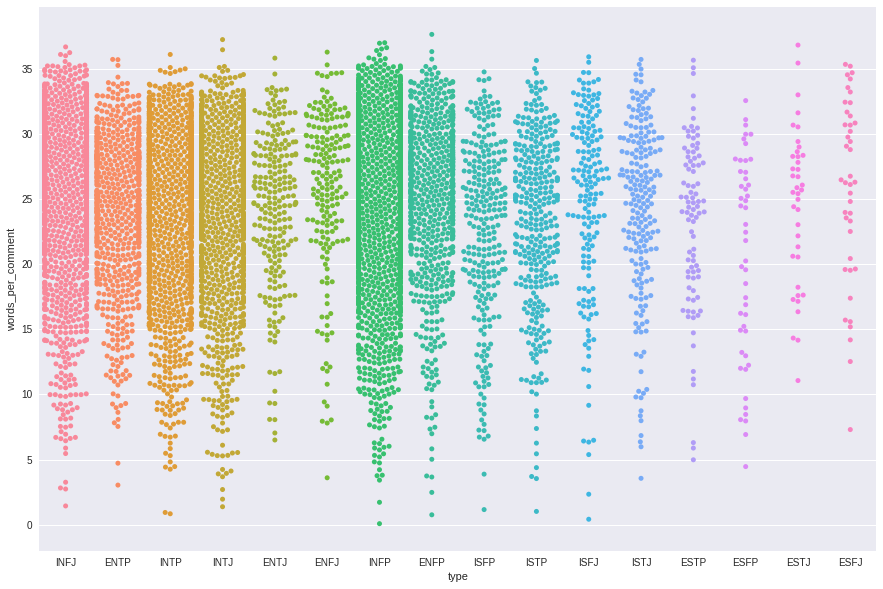

In [56]:
plt.figure(figsize=(15,10))
sns.swarmplot("type","words_per_comment", data=df_train)

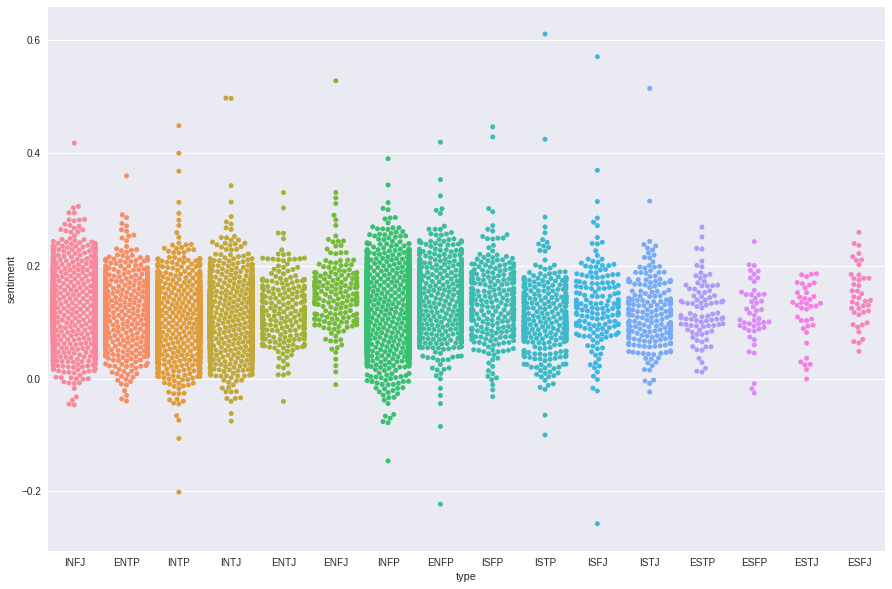

In [57]:
plt.figure(figsize=(15,10))
sns.swarmplot("type","sentiment", data=df_train)

## Trying Some Models (w.r.t. E vs. I, S vs. N, F vs. T, J vs. P)

xgboost of course





In [0]:
import sklearn

from sklearn.model_selection import train_test_split
from sklearn import cross_validation

In [0]:
# X = df_train.drop(['type'],axis = 1)
# y = df_train['type'].iloc(0,:)

# one hot encode type
# type_dummies = pd.get_dummies(df_train['type'])

# X = df_train.drop(['type'],axis = 1).join(type_dummies)
# y = df_train['type']

In [0]:
# Extrovert/Introvert set
X_e = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_e = df_train['E']
print(df_train.columns)

In [0]:
# Sensing/Intuition set
X_s = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_s = df_train['S']

In [0]:
# Feeling/Thinking set
X_f = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_f = df_train['F']

In [0]:
# Judging/Perceiving set
X_j = df_train.drop(['posts', 'type','E','I','S','N','F','T','P','J'], 1)
y_j = df_train['J']

In [0]:
# Split the data set into a training set and a test set.
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size = 0.3, random_state = 0)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = 0.3, random_state = 0)

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size = 0.3, random_state = 0)

X_train_j, X_test_j, y_train_j, y_test_j = train_test_split(X_j, y_j, test_size = 0.3, random_state = 0)

In [65]:
model_xgb_e = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_e.fit(X_train_e, y_train_e)

model_xgb_s = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_s.fit(X_train_s, y_train_s)

model_xgb_f = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_f.fit(X_train_f, y_train_f)

model_xgb_j = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=250)
model_xgb_j.fit(X_train_j, y_train_j)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=250, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

## Feature Selection:

Let's see which features are most important: 

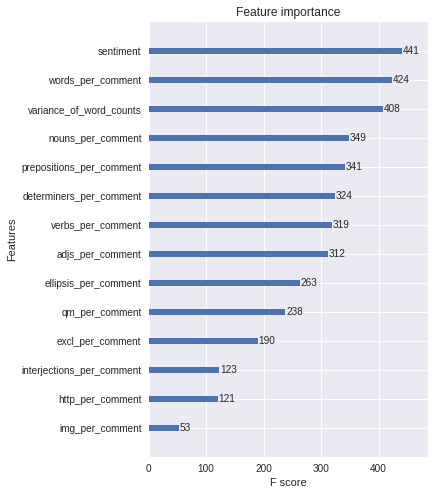

In [66]:
# Extrovert/Introvert
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_e, ax=ax)
plt.show()

Looks like the most important features for determining if someone is an extrovert is words_per_comment, variance_of_word_counts, and ellipsis_per_comment

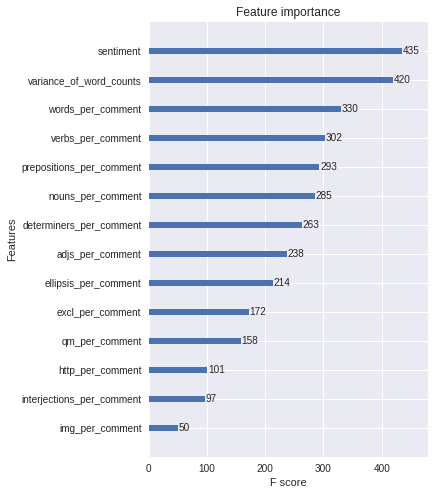

In [67]:
# For Sensing/Intuition
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_s, ax=ax)
plt.show()

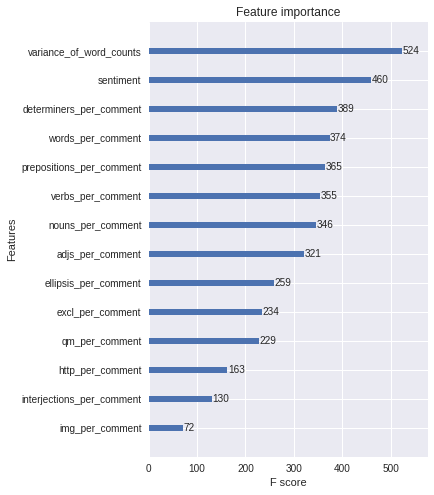

In [68]:
# Thinking/Feeling
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_f, ax=ax)
plt.show()

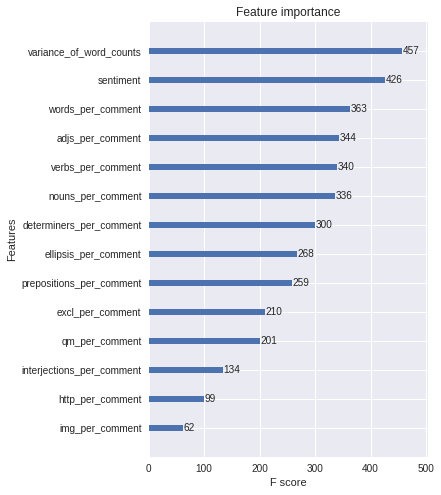

In [69]:
# Judging/Perceiving
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb_j, ax=ax)
plt.show()

# Build a model: Random Forest


In [0]:
from sklearn.ensemble import RandomForestClassifier

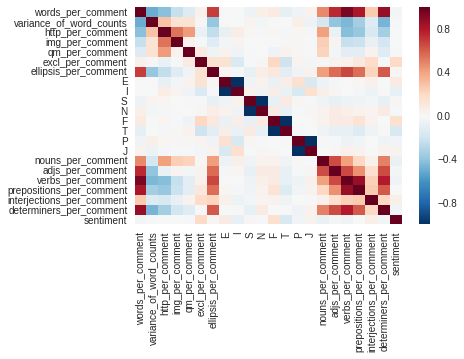

In [71]:
sns.heatmap(df_train.corr())

In [0]:
# One-hot encode the data using pandas get_dummies
features = pd.get_dummies(df_train)
# Display the first 5 rows of the last 12 columns
# features.iloc[:,5:].head(5)

In [0]:
# Labels are the values we want to predict
labels = np.array(features['E'])

In [0]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [0]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [0]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')